In [93]:
import numpy as np
import matplotlib.pyplot as plt
import run_LF as LF

%matplotlib inline
plt.style.use(['seaborn-poster','seaborn-ticks'])

In [94]:
%reload_ext autoreload
%autoreload 2

# Defining observational variables from Konno, Ouchi data

In [246]:
Ouchi_info6 = LF.ouchi_data_plt(zval_test = 6.6, plot = False, mean = False)
Konno_info6 = LF.konno_data_plt(zval_test = 6.6, plot = False, mean = False)
Konno_info7 = LF.konno_data_plt(zval_test = 7.3, plot = False, mean = False)
Shibuya_info7 = LF.shibuya_data_plt(zval_test = 7.3, plot = False, mean = False)

In [248]:
# z = 6.6
log_L6 = np.concatenate((Ouchi_info6[0], Konno_info6[0]), axis=None)
ndens6 = np.concatenate((Ouchi_info6[1], Konno_info6[1]), axis=None)
yerror_l6 = np.concatenate((Ouchi_info6[2][0], Konno_info6[2][0]), axis=None)
yerror_u6 = np.concatenate((Ouchi_info6[2][1], Konno_info6[2][1]), axis=None)

In [249]:
# z = 7.3
log_L7 = np.concatenate((Shibuya_info7[0], Konno_info7[0]), axis=None)
ndens7 = np.concatenate((Shibuya_info7[1], Konno_info7[1]), axis=None)
yerror_l7 = np.concatenate((Shibuya_info7[2][0], Konno_info7[2][0]), axis=None)
yerror_u7 = np.concatenate((Shibuya_info7[2][1], Konno_info7[2][1]), axis=None)

# Establishing prior, likelihood, & posterior

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


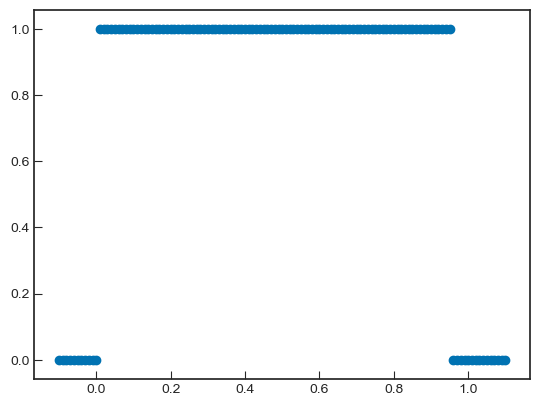

In [250]:
xHI_min = 0.
xHI_max = 0.95

# xHI_grid = np.linspace(-0.1,1.1)
xHI_grid = np.arange(-0.1, 1.1, 0.01)
def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """
    xHI = theta
    prob_xHI = np.zeros(len(xHI))
    
    
    prob_xHI[(xHI_min <= xHI) & (xHI <= xHI_max)] = 1. # Log prior (not worrying about normalization)


    ln_prior = np.log(prob_xHI)  # Log of the probability
    return ln_prior
# plt.scatter(xHI_grid, [np.exp(log_prior(xHI)) for xHI in xHI_grid])
plt.scatter(xHI_grid, np.exp(log_prior(xHI_grid)))

In [251]:
def log_likelihood(theta, x, y, dy_l, dy_u, z):
    """
    Returns log(likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    x: list, array-like
        x-values of your data
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    
    Returns
    -------
    ln_like: float
        Natural log of the likelihood function
    """
    xHI_mod = theta
    
    #Nearest neighbor to xHI list
    idx = (np.abs(LF.xHI_list - xHI_mod)).argmin()
    xHI_grid_match = LF.xHI_list[idx]
    
    y_model = LF.xHI_model(xHI_grid_match, obs_L = x, zval= z)
    
    #Defining split-likelihood
    #chi2 use split
    A = (np.sqrt(2.*np.pi)*(((dy_u + dy_l)/2.)**2.))**(-1)
    
    likelihood = A * np.exp(-0.5* ((y_model - y)**2.)/(dy_u**2.))

    likelihood2 = A * np.exp(-0.5* ((y_model - y)**2.)/(dy_l**2.))
    
    likelihood[y_model >= y] = likelihood2[y_model >= y]
    ln_like = np.sum(np.log(likelihood))
   
    return ln_like


In [252]:
def log_posterior(theta, x, y, dy_l, dy_u, z):
    """
    Returns log(posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    x: list, array-like
        x-values of your data
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    
    Returns
    -------
    ln_post: float
        Natural log of the posterior probability function
    """

    ln_post = log_prior(theta) + np.array([log_likelihood(t, x, y, dy_l, dy_u, z) for t in theta])  # From Bayes Theorem
    return ln_post
log_post6 = log_posterior(theta = xHI_grid, x = log_L6, y = ndens6, dy_l = yerror_l6, dy_u = yerror_u6, z = 6.6)
log_post7 = log_posterior(theta = xHI_grid, x = log_L7, y = ndens7, dy_l = yerror_l7, dy_u = yerror_u7, z = 7.3)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [253]:
# z = 6.6 
linear_post6 = np.exp(log_post6)
integral_post6 = np.trapz(linear_post6,xHI_grid)
normalized_post6 = linear_post6 / integral_post6

In [254]:
# Confidence interval information, z = 6.6
CDF_6 = np.cumsum(normalized_post6*np.gradient(xHI_grid))
CDF_norm_6 = CDF_6/CDF_6.max()

# 68% Confidence Interval upper limit
z6_CI68 = np.interp(0.68, CDF_norm_6, xHI_grid)
print(z6_CI68)

# 95% Confidence Interval upper limit
z6_CI95 = np.interp(0.95, CDF_norm_6, xHI_grid)
print(z6_CI95)

0.07293964504622646
0.15895709539263628


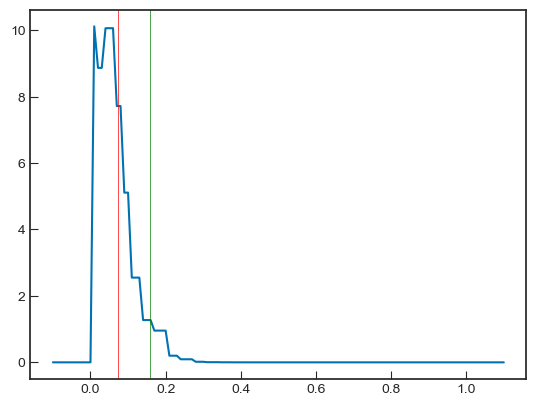

In [255]:
plt.plot(xHI_grid, normalized_post6)
plt.axvline(z6_CI68, color = 'red', lw = 0.5)
plt.axvline(z6_CI95, color = 'green', lw = 0.5)

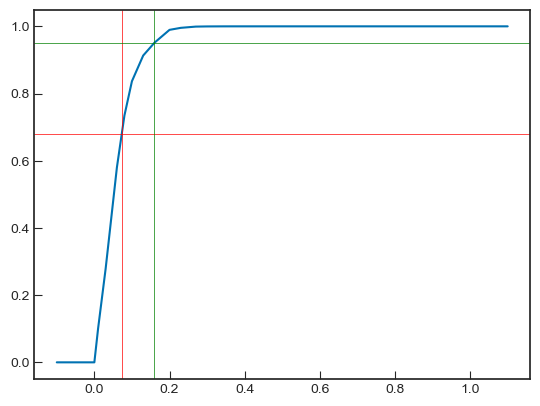

In [256]:
plt.plot(xHI_grid, CDF_norm_6)

# 68% CI upper limit
plt.axhline(0.68, color = 'red', lw = 0.5)
plt.axvline(z6_CI68, color = 'red', lw = 0.5)

# 95% CI upper limit
plt.axhline(0.95, color = 'green', lw = 0.5)
plt.axvline(z6_CI95, color = 'green', lw = 0.5)

In [257]:
# z = 7.3
linear_post7 = np.exp(log_post7)
integral_post7 = np.trapz(linear_post7,xHI_grid)
normalized_post7 = linear_post7 / integral_post7

In [258]:
# Confidence interval information, z = 7.3

CDF_7 = np.cumsum(normalized_post7*np.gradient(xHI_grid))
CDF_norm_7 = CDF_7/CDF_7.max()

# 68% Confidence Interval lower, median, upper limit
z7_CI16 = np.interp(0.16, CDF_norm_7, xHI_grid)
z7_CI50 = np.interp(0.5, CDF_norm_7, xHI_grid)
z7_CI84 = np.interp(0.84, CDF_norm_7, xHI_grid)
print(z7_CI16)
print(z7_CI50)
print(z7_CI84)

# 95% Confidence Interval lower, upper limit
z7_CI025 = np.interp(0.025, CDF_norm_7, xHI_grid)
z7_CI975 = np.interp(0.975, CDF_norm_7, xHI_grid)
print(z7_CI025)
print(z7_CI975)

0.9321011747180281
0.9414943168176103
0.9472781813816349
0.9213030829957012
0.9495747158408799


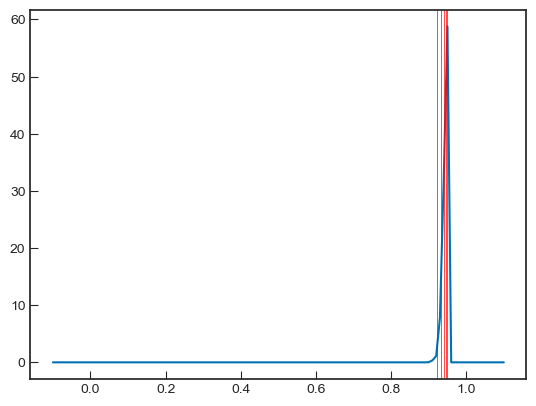

In [259]:
plt.plot(xHI_grid, normalized_post7)

# 68% CI lower, median, upper limit
plt.axvline(z7_CI16, color = 'red', lw = 0.5)
plt.axvline(z7_CI50, color = 'red', lw = 0.5)
plt.axvline(z7_CI84, color = 'red', lw = 0.5)

# 95% CI lower, upper limit
plt.axvline(z7_CI025, color = 'green', lw = 0.5)
plt.axvline(z7_CI975, color = 'green', lw = 0.5)

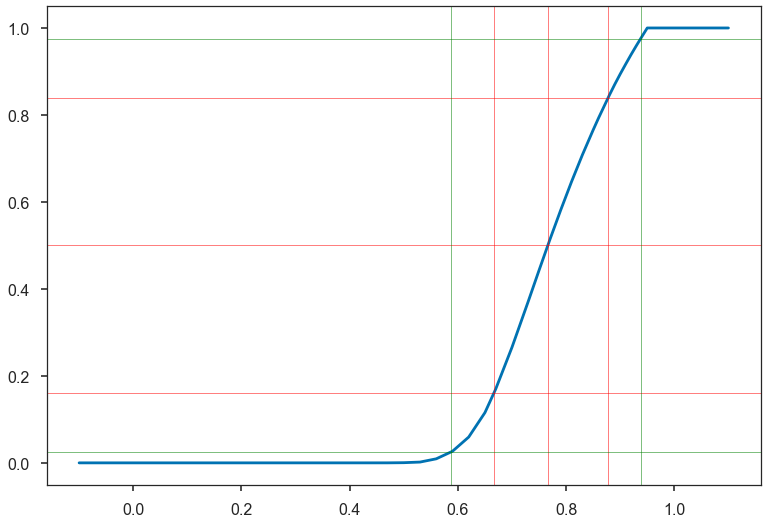

In [233]:
plt.plot(xHI_grid, CDF_norm_7)

# 68% CI lower, median, upper limit
plt.axhline(0.16, color = 'red', lw = 0.5)
plt.axhline(0.5, color = 'red', lw = 0.5)
plt.axhline(0.84, color = 'red', lw = 0.5)
plt.axvline(z7_CI16, color = 'red', lw = 0.5)
plt.axvline(z7_CI50, color = 'red', lw = 0.5)
plt.axvline(z7_CI84, color = 'red', lw = 0.5)

# 95% CI lower, upper limit
plt.axhline(0.025, color = 'green', lw = 0.5)
plt.axhline(0.975, color = 'green', lw = 0.5)
plt.axvline(z7_CI025, color = 'green', lw = 0.5)
plt.axvline(z7_CI975, color = 'green', lw = 0.5)


# Test Code

In [97]:
#Test Cell
np.random.seed(0)

y_model = np.ones(10)
y = np.random.rand(10)+0.5
likelihood = (y_model - y)**2.
print(likelihood)
print(y)
# likelihood[y_model >= y] = 0
# print(likelihood)

likelihood2 = -(y_model - y)**2.
# print(likelihood2)
likelihood[y_model >= y] = likelihood2[y_model >= y]
print(likelihood)

[0.00238276 0.04630646 0.01056031 0.0020145  0.00582859 0.02128509
 0.00389536 0.15348608 0.21498316 0.01358588]
[1.0488135  1.21518937 1.10276338 1.04488318 0.9236548  1.14589411
 0.93758721 1.391773   1.46366276 0.88344152]
[ 0.00238276  0.04630646  0.01056031  0.0020145  -0.00582859  0.02128509
 -0.00389536  0.15348608  0.21498316 -0.01358588]
